In [ ]:
'''

2. Ablation Study
Ablation Study가 무엇인지 알아봅니다.

3. CIFAR-10 데이터셋 준비
학습을 위해 CIFAR-10 데이터셋을 준비합니다.

4. 블록 구성
VGG 기본 블록을 만들어봅니다.

5. VGG Complete Model
VGG 모델을 만들어봅니다.

6. VGG-16 vs VGG-19
VGG-16과 VGG-19를 비교실험 합니다.



ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?

블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.


구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?

tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.


Ablation Study 결과가 바른 포맷으로 제출되었는가?

ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

'''

In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [4]:
root_dir = os.getcwd()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10( root=root_dir,train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=root_dir,train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [13]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[5300]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")
print(f"Number of train set: ", len(trainset))

Image shape: torch.Size([3, 32, 32])
Label: 9
Number of classes: 10
Number of train set:  50000


In [14]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))


In [15]:
num_classes = len(trainset.classes)
print(num_classes)

10


In [49]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [17]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [30]:
def show_multiple_images(dataset, n_images=25):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(5, 5, figsize=(7, 7))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

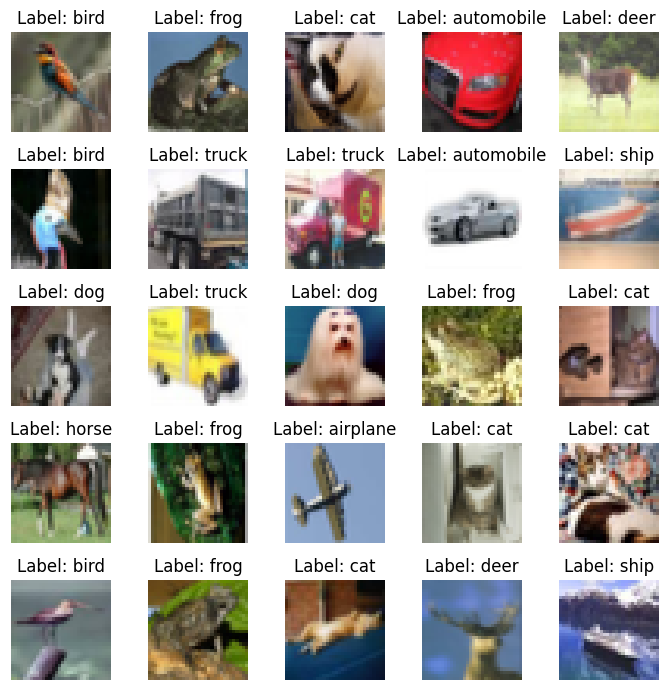

In [31]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

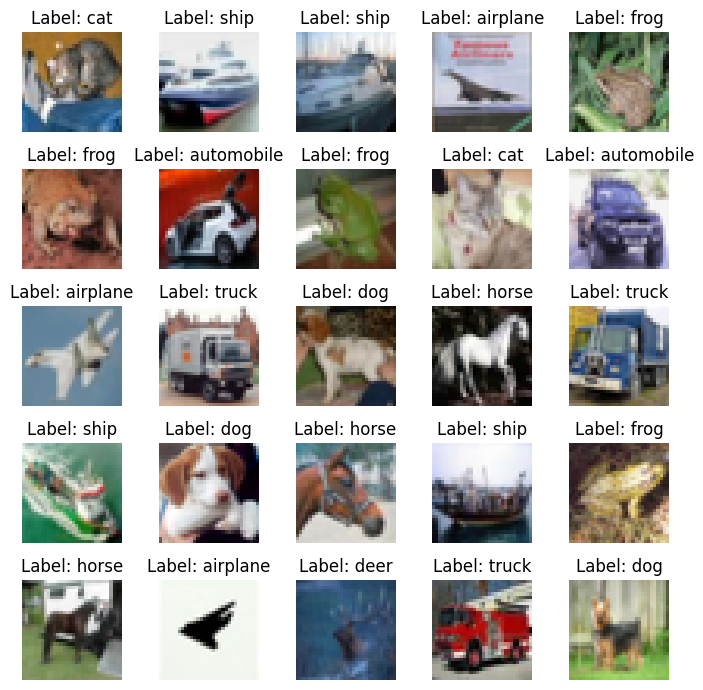

In [32]:
show_multiple_images(testloader)

In [2]:
def build_vgg_block(input_layer,
                    num_cnn  =3,
                    channel = 64,
                    block_num = 1):
    x = input_layer
    # 왜 input_layer를 x로 다시 담지

    layer = [] #layer 라는 리스트
    in_channels = x.size(1) # input_layer의 두번째 텐서 == 채널 수

    for cnn_num in range(num_cnn): #num_cnn 만큼
        layer.append(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=channel,
                kernel_size=3,
                stride=1,
                padding=1
            )
        )
        layer.append(nn.ReLU(inplace=True))  # in_channels 는 input_layer의 두번째 텐서 
        in_channels = channel
    
    layer.append(
        nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
    )

    block = nn.Sequential(*layer)
    return block

'''
Conv + ReLU x n + MaxPool

input_layer: 이전 블록의 출력 (특징 맵 텐서)

num_cnn: 몇 개의 Conv 층을 쌓을지 

channel: 해당 블록의 출력 채널 수

block_num: 블록 번호 이 함수 내부에서는 실제 사용 x

x = torch.randn(1, 3, 32, 32)
vgg_block = build_vgg_block(x, num_cnn=2, channel=64)

Sequential(
  (0): Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2)
)

????
'''

'\nConv + ReLU x n + MaxPool\n\ninput_layer: 이전 블록의 출력 (특징 맵 텐서)\n\nnum_cnn: 몇 개의 Conv 층을 쌓을지 \n\nchannel: 해당 블록의 출력 채널 수\n\nblock_num: 블록 번호 이 함수 내부에서는 실제 사용 x\n\nx = torch.randn(1, 3, 32, 32)\nvgg_block = build_vgg_block(x, num_cnn=2, channel=64)\n\nSequential(\n  (0): Conv2d(3, 64, kernel_size=3, stride=1, padding=1)\n  (1): ReLU(inplace=True)\n  (2): Conv2d(64, 64, kernel_size=3, stride=1, padding=1)\n  (3): ReLU(inplace=True)\n  (4): MaxPool2d(kernel_size=2, stride=2)\n)\n\n????\n'

In [3]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        # VGG 블록 생성
        self.vgg_block = build_vgg_block(torch.zeros(1, 3, 32, 32))
    def forward(self, x):
        return self.vgg_block(x)

In [4]:
# 블록 1개짜리 model 생성
model = VGGNet()
print(model)

dummy_input = torch.zeros(1, 3, 32, 32)
output = model(dummy_input)
print(output.shape)

VGGNet(
  (vgg_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([1, 64, 16, 16])


In [41]:
# VGG 모델 자체를 생성하는 클래스입니다.
class VGG(nn.Module):
    def __init__(self, num_cnn_list=[2, 2, 3, 3, 3], channel_list=[64, 128, 256, 512, 512], num_classes=10):
        super(VGG, self).__init__()
        assert len(num_cnn_list) == len(channel_list), "num_cnn_list와 channel_list의 길이가 일치해야 합니다."

        layers = []
        in_channels = 3

        for num_cnn, out_channels in zip(num_cnn_list, channel_list):
            layers.append(self._make_vgg_block(in_channels, out_channels, num_cnn))
            in_channels = out_channels  # 다음 블록의 입력 채널을 설정

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes)
        )

    def _make_vgg_block(self, in_channels, out_channels, num_cnn):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU(True)]
        for _ in range(num_cnn - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Max Pooling 추가
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [42]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.

vgg_16 = VGG()
print(vgg_16)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [44]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = VGG(
    num_cnn_list=[2, 2, 4, 4, 4],
    channel_list=[64, 128, 256, 512, 512]
)
print(vgg_19)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [45]:
# Q. VGG-16보다 작은 네트워크인 VGG-13을 만들어 보세요.
def build_vgg13(num_classes=10):
    return VGG(
        num_cnn_list=[2, 2, 2, 2, 2],
        channel_list=[64, 128, 256, 512, 512],
        num_classes=num_classes
    )

In [46]:
vgg_13 = build_vgg13()
print(vgg_13)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [53]:
BATCH_SIZE = 256
EPOCH = 40

In [51]:
root_dir = os.getcwd()

transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG-16 표준 정규화
])

trainset = torchvision.datasets.CIFAR10( root=root_dir,train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=root_dir,train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [54]:
import time

current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_16 = torchvision.models.vgg16(pretrained=True)
vgg_16.to(device)

for param in vgg_16.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_16.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_16_train_losses = []
vgg_16_val_accuracy = []

for epoch in range(EPOCH):
    vgg_16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    vgg_16_train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_16.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_16(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_16_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

[1,   100] loss: 2.916
Epoch 1: Train Accuracy: 39.90%
Epoch 1: Validation Accuracy: 67.29%
[2,   100] loss: 0.881
Epoch 2: Train Accuracy: 71.44%
Epoch 2: Validation Accuracy: 75.73%
[3,   100] loss: 0.647
Epoch 3: Train Accuracy: 78.45%
Epoch 3: Validation Accuracy: 79.31%
[4,   100] loss: 0.531
Epoch 4: Train Accuracy: 82.24%
Epoch 4: Validation Accuracy: 80.70%
[5,   100] loss: 0.451
Epoch 5: Train Accuracy: 84.81%
Epoch 5: Validation Accuracy: 81.79%
[6,   100] loss: 0.388
Epoch 6: Train Accuracy: 86.56%
Epoch 6: Validation Accuracy: 81.99%
[7,   100] loss: 0.333
Epoch 7: Train Accuracy: 88.63%
Epoch 7: Validation Accuracy: 82.82%
[8,   100] loss: 0.297
Epoch 8: Train Accuracy: 90.00%
Epoch 8: Validation Accuracy: 83.74%
[9,   100] loss: 0.259
Epoch 9: Train Accuracy: 91.20%
Epoch 9: Validation Accuracy: 84.27%
[10,   100] loss: 0.220
Epoch 10: Train Accuracy: 92.42%
Epoch 10: Validation Accuracy: 84.66%
[11,   100] loss: 0.198
Epoch 11: Train Accuracy: 93.56%
Epoch 11: Validation

In [55]:
current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_19 = torchvision.models.vgg19(pretrained=True)
vgg_19.to(device)

for param in vgg_19.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_19.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_19_train_losses = []
vgg_19_val_accuracy = []

for epoch in range(EPOCH):
    vgg_19.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    train_loss = running_loss / len(trainloader)
    vgg_19_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_19.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_19(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_19_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

c:\Users\C\anaconda3\envs\jedi\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\C/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:59<00:00, 9.59MB/s] 


[1,   100] loss: 2.703
Epoch 1: Train Accuracy: 43.72%
Epoch 1: Validation Accuracy: 69.83%
[2,   100] loss: 0.806
Epoch 2: Train Accuracy: 74.50%
Epoch 2: Validation Accuracy: 77.82%
[3,   100] loss: 0.565
Epoch 3: Train Accuracy: 80.98%
Epoch 3: Validation Accuracy: 81.66%
[4,   100] loss: 0.494
Epoch 4: Train Accuracy: 83.89%
Epoch 4: Validation Accuracy: 83.31%
[5,   100] loss: 0.410
Epoch 5: Train Accuracy: 86.23%
Epoch 5: Validation Accuracy: 84.41%
[6,   100] loss: 0.355
Epoch 6: Train Accuracy: 88.11%
Epoch 6: Validation Accuracy: 85.17%
[7,   100] loss: 0.313
Epoch 7: Train Accuracy: 89.48%
Epoch 7: Validation Accuracy: 85.81%
[8,   100] loss: 0.275
Epoch 8: Train Accuracy: 90.70%
Epoch 8: Validation Accuracy: 85.47%
[9,   100] loss: 0.231
Epoch 9: Train Accuracy: 92.02%
Epoch 9: Validation Accuracy: 86.38%
[10,   100] loss: 0.198
Epoch 10: Train Accuracy: 93.20%
Epoch 10: Validation Accuracy: 86.22%
[11,   100] loss: 0.165
Epoch 11: Train Accuracy: 94.42%
Epoch 11: Validation

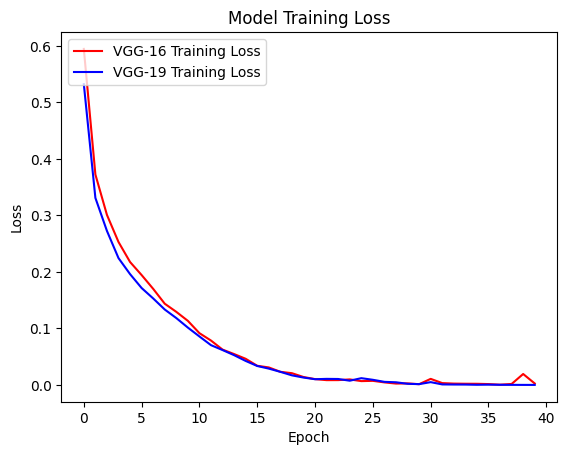

In [56]:
import matplotlib.pyplot as plt

plt.plot(vgg_16_train_losses, 'r', label="VGG-16 Training Loss")
plt.plot(vgg_19_train_losses, 'b', label="VGG-19 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

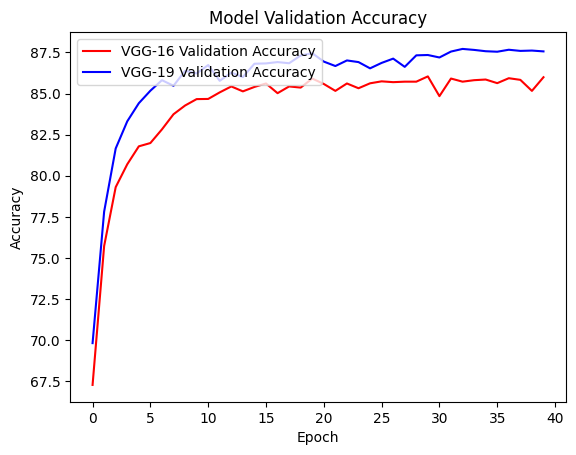

In [57]:
plt.plot(vgg_16_val_accuracy, 'r', label="VGG-16 Validation Accuracy")
plt.plot(vgg_19_val_accuracy, 'b', label="VGG-19 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()